# SCAM/LES Output Plotting Package
## Set up modules (standard and mine) 

In [1003]:
### Import Standard Packages ###
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import metpy.calc as mpc
import metpy.constants as mconst
import xarray as xr
import scipy as spy
import pandas as pd
import datetime as dt
import cartopy


### To Import My Functions ###
import scam_func as mypy
import importlib


#### CONSTANTS #####
r_gas = mconst.dry_air_gas_constant.magnitude   # Specific gas constant for dry air
cp_air = mconst.dry_air_spec_heat_press.magnitude # Specific heat for dry air
Lv = mconst.water_heat_vaporization.magnitude       # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = mconst.earth_gravity.magnitude       # Gravity ave.
p0 = mconst.pot_temp_ref_press.magnitude

#%xmode Plain   ## Fortran-like error tracebacks (doesn't seem to work though)

# Add Experiment Set 

In [1008]:

#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######

#case_iop = "PERDIGAO" ; scam_file_nums = ['001','002','003','004'] ; scam_run_names = ['x01','x02','x03','x04']
case_iop = "SAS" ; scam_file_nums = ['106.norad','106d.norad','LES'] ; scam_run_names = ['CAM6-L32','CAM6-L256','NCAR']
case_iop = "SAS" ; 
#case_iop = "RICO" ; scam_file_nums = ['001'] ; scam_run_names = ['RICO1']





#scam_file_nums = ['106.norad','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L32-NoRad','NCAR']

########## BASE DIRS ############

dir_root = '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/'




# Diagnostic Field Selections
## List of variables for each plot type

In [1009]:
# Global Vars. #

fig_file = True # Need to add this in RBN
fig_screen = True
pvars_list = False # List all variables that can be plotted in each 'set'



#### PLOTTING ####

""" ### ### ### ### """
""" ###  1D TS  ### """
""" ### ### ### ### """
#pvars_ts1d = np.array(['PBLH','TS','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts1d = np.array(['SHFLX','LHFLX','PBLH','PBLH_DQ'])

pvars_ts1d = np.array(['LHFLX'])



""" ### ### ### ### """
""" ###  2D TS  ### """
""" ### ### ### ### """

## WPSKEW is WP3_CLUBB/WP2_CLUBB**3/2
#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT', 
#            'STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','WP3_CLUBB','THLP2_CLUBB','WP2_CLUBB'] # 2D profile timeseries plots
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
#pvars_ts2d = ['THV','TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB']
pvars_ts2d = ['TH']


""" ### ### ### ### ### """
""" ### 1D SNAPSHOT ### """
""" ### ### ### ### ### """

#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']\
#pvars_ts2d = ['STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB'] 
    
#pvars_snap = ['TH','THL','Q','RELHUM','DTV','DCQ','STEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']
#pvars_snap = ['TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB']
pvars_snap = ['TH']

tsnaps = np.array([6.,8.,10.,12.,14.,16.])     # Time of snapshots (local time)

""" ### ### ### ###  ### """
""" ### PROF BUDGETS ### """  # Not used yet
""" ### ### ### ###  ### """




""" ### ### ### ### ### """
""" ### ANIMATIONS ###  """ # Not used yet
""" ### ### ### ### ### """
    
pvars_anim = np.array(('Q'))





# File and Array Setups 

In [1010]:

####### DERIVED VARS #######

scam_fig_stub=dir_root+'png/'+case_iop+'_'.join(scam_file_nums)


### Bundle these into array for passing to functions ###
run_info = {}
run_info['pvars_list'] = pvars_list
run_info['1dvars'] = pvars_ts1d
run_info['2dvars'] = pvars_ts2d
run_info['snapvars'] = pvars_snap

####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
%matplotlib inline


### Change List to np array ### 

scam_file_nums = np.array(scam_file_nums) 
scam_run_names = np.array(scam_run_names) 


# SCAM in IOP-LES format
#ii = [ix for ix, x in enumerate(scam_file_nums) if x == 'LES']# Change to LES-IOP-format file if needed 
#for i in ii: scam_files_in[i] = dir_main+'history/'+scam_file_pre+scam_file_nums[0]+scam_file_suf+'_'+case_iop+'_format.nc' 

# LES in IOP-LES format
#scam_files_in = np.where(scam_run_names == 'NCAR', dir_main+'LES/'+les_files_in['NCAR'],scam_files_in) # Change to LES file if needed



### Bundle run info ###
run_info['Case IOP']   = case_iop
run_info['Run Name']   = scam_run_names
run_info['File Num']   = scam_file_nums
run_info['Stub Figs']  = scam_fig_stub
run_info['Snap Times']  = tsnaps
run_info['Dir Root'] = dir_root

#df_rinfo = pd.DataFrame(rinfo)
#df_rinfo.style.set_properties(**{'background-color': 'white','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})


# Plot type selection 

+++ IMPORTING MY FUNCTIONS +++

SAS  - 1D SNAPSHOT PLOTTING VARIABLES

---- PLOTTING 1D HEIGHT SNAPSHOT PLOTS ------>>>  
 -  TH   -  Potential Temperature  --
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106.norad*nc
 -->   CAM6-L32  --  106.norad  --  296.5928449813862 1276.77857031502
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.norad*nc
 -->   CAM6-L256  --  106d.norad  --  296.59380218662085 1489.5137826667005
 -->   NCAR  --  LES  --  296.57185571369394 305.75000000000006



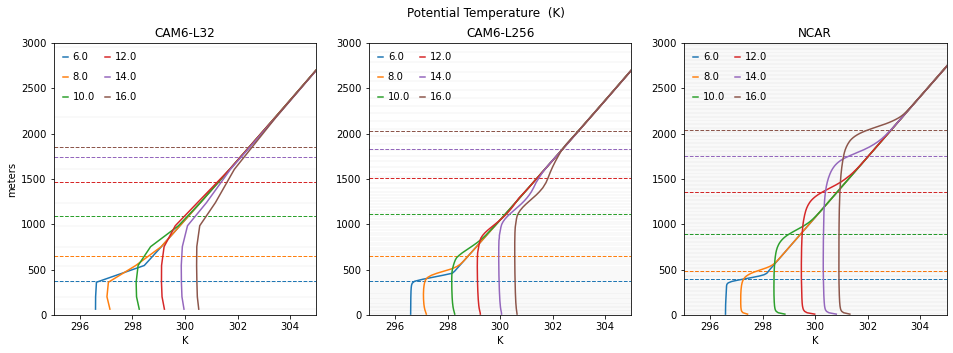

In [1014]:
###### Plotting ##########

importlib.reload(mypy) # Required because I am constantly editing scam_func.py

#dir(mypy)

###### PLOTS ######

#mypy.plot1d_ts_scam(run_info)   # 1D time series plots
#mypy.plot2d_ts_scam(run_info)   # 2D time series plots
mypy.plot1d_snap_scam(run_info)   # 1D snapshot plots
#mypy.plot1d_anim_scam(run_info) # 2D profile animation plots

## New plot sets
#mypy.plot1d_mean_scam(run_info)   # 1D mean profiles
#mypy.plot1d_budget_scam(run_info)   # 1D mean profiles

#mypy.plot2d_budget_scam(run_info)   # 1D [TO DO]
